# Listing Price Prediction Model from Scraped Airbnb Data

## Notebook Contents

#### Data Exploration
* Explore with histograms and scatter matrices
* Plot correlation matrix of features

#### Data Preprocessing
* Transform skewed variables (Price, Review Count)
* Map Room Type feature
* Make binomial feature Has_Star_Rating
* Add feature mean-Price for each city
* Combine each city's DF into one DF to train model on

#### Listing Price Prediction
* Fit baseline model (linear regression with avg price for each city)
* Find optimal Ridge Regression model with combinations of features
* Tune alpha parameter of optimal model
* Explore how Ridge model performs under different training set sizes
* Try fitting a more complex Gradient Boosted Regression model (not optimistic it will ouperform)

In [170]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Additional imports
from sklearn import metrics
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
import time

In [2]:
# ignore warnings on setting values ona  copy of a DF
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def load_df(df_file):
    # function to load csv files from data folder into DataFrame
    basepath = 'data/'
    filepath = basepath + df_file
    load_df = pd.DataFrame.from_csv(filepath)
    return load_df

In [4]:
# load the scraped datasets
ny_df = load_df('NY_df.csv')
la_df = load_df('LA_df.csv')
sf_df = load_df('SF_df.csv')

## Data Exploration

### Exploring NY data (in earlier notebook, LA and SF data explored in same way and confirmed to have similar distributions. Will only show NY exploration here for readability)
* Generate feature & response histograms and scatter matrices
* Plot correlation matrix

In [46]:
ny_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating
0,1,2,6882689,198,Apartment,17,Entire home/apt,5
1,2,7,12022627,2200,Apartment,0,Entire home/apt,0
2,1,2,8940740,149,Apartment,6,Entire home/apt,5
3,1,4,12035970,55,Apartment,0,Entire home/apt,0
4,1,2,11642165,65,Apartment,3,Private room,5


In [5]:
# Limit DF to columns we'll consider as features (and Price)
ny_feature_cols = ['Bedrooms','Capacity','Price','Review_Count','Room_Type','Star_Rating']
feature_ny_df = ny_df[ny_feature_cols]

In [48]:
# Take a look at pandas describe function
feature_ny_df.describe()

,Bedrooms,Capacity,Price,Review_Count,Star_Rating
count,306.000000,306.000000,306.000000,306.000000,306.000000
mean,0.869281,2.218954,104.428105,14.601307,3.485294
std,0.460830,1.056332,129.893511,24.689904,2.142607
min,0.000000,1.000000,20.000000,0.000000,0.000000
25%,1.000000,2.000000,61.250000,2.000000,0.000000
50%,1.000000,2.000000,90.000000,5.000000,4.500000
75%,1.000000,2.000000,119.000000,15.000000,5.000000
max,3.000000,8.000000,2200.000000,180.000000,5.000000


All columns have the same count, so no need to deal with missing values. Let's take a look at histograms of the variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113f66d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114500dd0>]], dtype=object)

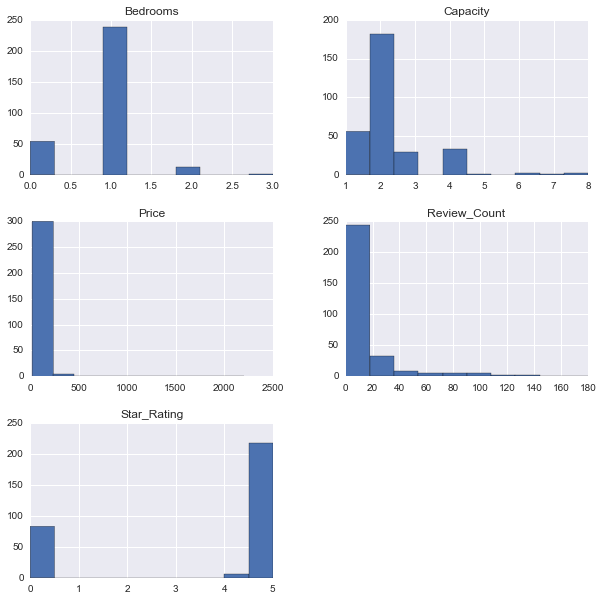

In [49]:
feature_ny_df.hist(figsize=(10,10))

### Thoughts on histograms
* Bedrooms and Capacity look as expected.
* Price has an outlier at $2200, that is ruining the histogram. We must deal with it.
* Review Count is left skewed and should be logged for any model that req's norm. dist features.
* Star Rating is essentially binomial with a rating of either 0 or 5. Could map from continuous to binomial.

### Let's remove that outlier from Price and re-plot:

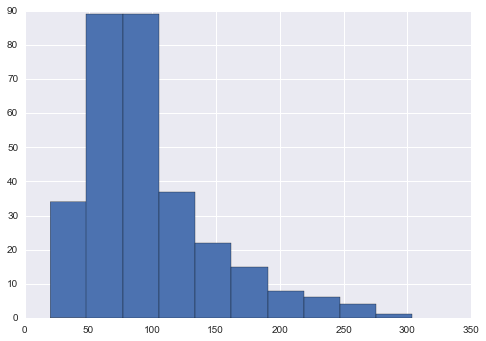

In [51]:
price_outlier_mask = feature_ny_df.Price<2000
feature_ny_df = feature_ny_df[price_outlier_mask]
feature_ny_df.Price.hist()

That looks better. Same as Review Count, Price is left skewed and could benefit from a log tranformation to make it more normally distributed. Let's see what that looks like:

In [52]:
feature_ny_df['log_Price'] = np.log(feature_ny_df.Price)

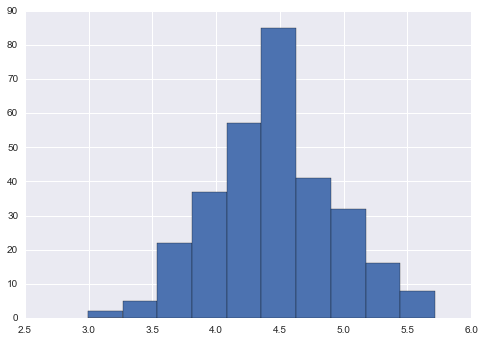

In [53]:
feature_ny_df.log_Price.hist()

The log of Price is normally distributed indeed!

### Scatter Matrices

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114d39c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118231810>]], dtype=object)

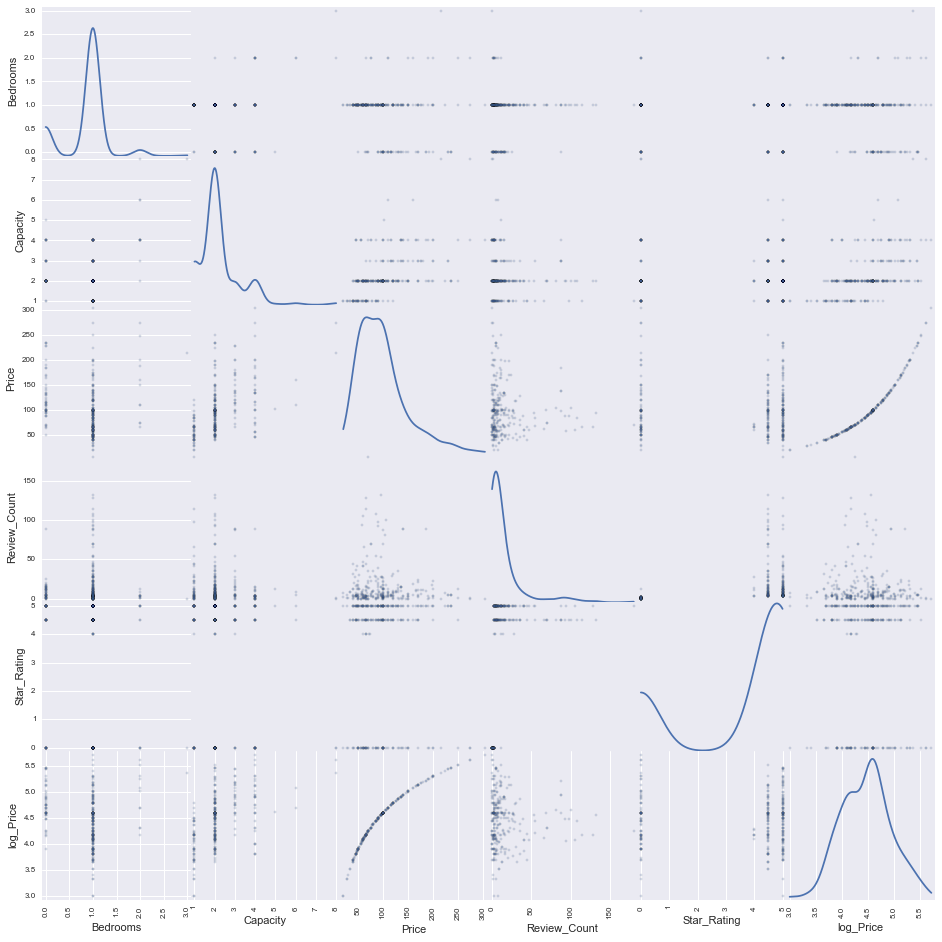

In [55]:
pd.tools.plotting.scatter_matrix(feature_ny_df, alpha=0.2, figsize=(16, 16), diagonal='kde')

#### Overall it does not look like any one feature is particularly correlated with Price (or Log(Price)). Let's look at the actual correlation numbers:

In [56]:
# check collinearity of feature variables
feature_ny_df[ny_feature_cols].corr()

,Bedrooms,Capacity,Price,Review_Count,Star_Rating
Bedrooms,1.000000,0.178469,-0.108111,0.038039,-0.050983
Capacity,0.178469,1.000000,0.500679,-0.108792,-0.090091
Price,-0.108111,0.500679,1.000000,-0.077515,-0.025455
Review_Count,0.038039,-0.108792,-0.077515,1.000000,0.319596
Star_Rating,-0.050983,-0.090091,-0.025455,0.319596,1.000000


#### Price and Capacity are relatively highly correlated at 0.5. No other feature is particularly correlated to Price. Star Rating and Review Count are reasonably correlated at 0.32, suggesting listings with many reviews are well-liked. 

#### Let's see how Property Type and Room Type categorical variables look:

In [58]:
ny_df.Property_Type.value_counts()

Apartment          280
House               14
Townhouse            5
Loft                 4
Other                1
Condominium          1
Bed & Breakfast      1
dtype: int64

In [59]:
ny_df.Room_Type.value_counts()

Private room       156
Entire home/apt    144
Shared room          6
dtype: int64

#### Too many Property Types to make one-hot-encoding worth it (too many additional features. However, will map Room Type to ordinal categorical variable type since I believe you can rank (in order of least desireable to most): 0 : Shared Room, 1 : Private Room, 2 : Entire home/apt

#### Next, I want to look if there's a relationship between listings with a Star Rating greater than 0 and Price (i.e. would I be throwing away valuable info if I mapped Star Rating to binomial.

In [61]:
feature_ny_df.Star_Rating.value_counts()

5.0    132
4.5     85
0.0     82
4.0      6
dtype: int64

In [64]:
sr_group_by = ny_df.groupby('Star_Rating').Price.mean()
sr_group_by

Star_Rating
0.0    125.722892
4.0     66.500000
4.5     93.458824
5.0     99.825758
Name: Price, dtype: float64

In [ ]:
star_rating_mask = feature_ny_df.Star_Rating>1.0
star_rating_df = feature_ny_df[star_rating_mask]

In [72]:
# Correlation between price and Star Rating for listings with a rating greater than 0
np.corrcoef(star_rating_df.Star_Rating, star_rating_df.Price)[0][1]

0.11085439208776988

#### There is some correlation between the Star Rating (when it is not 0) and Price. Though at 0.11 the correlation is not particularly strong. Looking at the Group By, interestingly, listings with a 0 star rating have a higher price. I believe these are properties that are naively priced and have not been stayed in much, if at all.

## Data Preprocessing
* Transform skewed variables (Price, Review Count)
* Map Room Type feature
* Make binomial feature Has_Star_Rating
* Add features mean-Price for each city
* Combine each city's DF into one DF to train model on

In [6]:
def preprocess_data(df, city):
    """Transform data to prepare for model training"""
    
    # add city
    df['City'] = city
    
    # get rid of the price outlier in the NY df
    if city == 'NY':
        price_outlier_mask = df.Price<2000
        df = df[price_outlier_mask]
    
    # add column for mean price (for baseline model)
    df['Avg_Price'] = df.Price.mean()
    
    # take log of price and add mean log(Price)
    df['log_Price'] = np.log(df.Price)
    df['log_Avg_Price'] = df.log_Price.mean()
    
    # Add log of Review Count
    df['log_Review_Count'] = np.log(df.Review_Count)
    
    # get rid of -infs as a result of logs on 0
    df['log_Review_Count'] = np.where(df.log_Review_Count<0, 0, df.log_Review_Count)
    
    # map Room Type variable
    df['Room_Type'] = df.Room_Type.map({'Shared room':0,'Private room':1, 'Entire home/apt':2})
    
    # make 'Has_Star_Rating' feature
    df['Has_Star_Rating'] = np.where(df['Star_Rating']>1.0, 1, 0)
    
    cols = ['Bedrooms','Capacity','Price','Review_Count','Room_Type','Star_Rating','City','Avg_Price',
           'log_Price','log_Avg_Price','log_Review_Count','Has_Star_Rating']
    
    return df[cols]
    #return df
    

In [7]:
processed_ny_df = preprocess_data(ny_df,'NY')

In [144]:
processed_ny_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating
0,1,2,198,17,2,5.0,NY,97.557377,5.288267,4.464576,2.833213,1
2,1,2,149,6,2,5.0,NY,97.557377,5.003946,4.464576,1.791759,1
3,1,4,55,0,2,0.0,NY,97.557377,4.007333,4.464576,0.000000,0
4,1,2,65,3,1,5.0,NY,97.557377,4.174387,4.464576,1.098612,1
5,1,1,61,66,1,4.5,NY,97.557377,4.110874,4.464576,4.189655,1


In [145]:
sf_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating
0,1,2,1692470,108,Apartment,186,Private room,5.0
1,1,1,7246789,140,Apartment,7,Private room,5.0
2,1,1,1093088,68,Apartment,106,Private room,5.0
3,1,3,3667551,110,Apartment,23,Private room,4.5
4,1,3,9347891,130,House,25,Entire home/apt,5.0


In [8]:
processed_sf_df = preprocess_data(sf_df,'SF')

In [147]:
processed_sf_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating
0,1,2,108,186,1,5.0,SF,123.065359,4.682131,4.705857,5.225747,1
1,1,1,140,7,1,5.0,SF,123.065359,4.941642,4.705857,1.945910,1
2,1,1,68,106,1,5.0,SF,123.065359,4.219508,4.705857,4.663439,1
3,1,3,110,23,1,4.5,SF,123.065359,4.700480,4.705857,3.135494,1
4,1,3,130,25,2,5.0,SF,123.065359,4.867534,4.705857,3.218876,1


In [148]:
la_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating
0,2,4,12038456,250,Apartment,0,Entire home/apt,0.0
1,1,2,10814985,42,Apartment,3,Private room,5.0
2,1,3,8226591,65,Apartment,7,Entire home/apt,4.5
3,2,4,9463896,140,House,9,Entire home/apt,4.5
4,0,2,12020409,169,House,2,Entire home/apt,0.0


In [9]:
processed_la_df = preprocess_data(la_df,'LA')

In [150]:
processed_la_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating
0,2,4,250,0,2,0.0,LA,83.980392,5.521461,4.338542,0.000000,0
1,1,2,42,3,1,5.0,LA,83.980392,3.737670,4.338542,1.098612,1
2,1,3,65,7,2,4.5,LA,83.980392,4.174387,4.338542,1.945910,1
3,2,4,140,9,2,4.5,LA,83.980392,4.941642,4.338542,2.197225,1
4,0,2,169,2,2,0.0,LA,83.980392,5.129899,4.338542,0.693147,0


### Now, with processed datasets for each city, we shall combine them into one DataFrame

In [10]:
def combine_dfs(df_list):
    data_frame = None
    for df in df_list:
        if data_frame is None:
            data_frame = df
        else:
            data_frame = data_frame.append(df)
    return data_frame

In [11]:
df_list = [processed_ny_df, processed_la_df, processed_sf_df]
combined_df = combine_dfs(df_list)

In [12]:
# One hot encode 'City' feature
# create three dummy variables using get_dummies, then exclude the first dummy column
city_dummies = pd.get_dummies(combined_df.City, prefix='City').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame
combined_df = pd.concat([combined_df, city_dummies], axis=1)
combined_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating,City_NY,City_SF
0,1,2,198,17,2,5.0,NY,97.557377,5.288267,4.464576,2.833213,1,1,0
2,1,2,149,6,2,5.0,NY,97.557377,5.003946,4.464576,1.791759,1,1,0
3,1,4,55,0,2,0.0,NY,97.557377,4.007333,4.464576,0.000000,0,1,0
4,1,2,65,3,1,5.0,NY,97.557377,4.174387,4.464576,1.098612,1,1,0
5,1,1,61,66,1,4.5,NY,97.557377,4.110874,4.464576,4.189655,1,1,0


In [13]:
# drop the 'City' column since it is no longer needed
combined_df.drop('City', axis=1,inplace=True)

## Listing Price Prediction
* Fit baseline model (linear regression with avg price for each city)
* Find optimal Ridge Regression model with combinations of features
* Tune alpha parameter of optimal model
* Explore how Ridge model performs under different training set sizes
* Try fitting a more complex Gradient Boosted Regression model (not optimistic it will ouperform)

In [14]:
def fit_baseline(df):
    """Fit baseline prediction model where we predict a city's avg for each listing"""
    predictions = df.log_Avg_Price
    y = df.log_Price
    base_r2 = metrics.r2_score(y, predictions)
    base_RMSE = np.sqrt(metrics.mean_squared_error(y, predictions))
    
    return (base_r2, base_RMSE)

In [15]:
base_r2, base_RMSE = fit_baseline(combined_df)
print "Baseline model R-squared: {:.3f}".format(base_r2)
print "Baseline model RMSE: {:.3f}".format(base_RMSE)

Baseline model R-squared: 0.100
Baseline model RMSE: 0.458


#### Baseline R-squared is 0.095, and RMSE is 0.458 Any future models must at least beat this baseline. Let's try Ridge Regression models

In [25]:
# all the features we will consider adding to the model
regression_features = ['log_Review_Count','Star_Rating','Has_Star_Rating','Bedrooms','Capacity','Room_Type','City_NY','City_SF']

In [38]:
feat_combinations = []
# make a list of every possible combination of features, 255 in total
for i in range(len(regression_features)):
   [feat_combinations.append(list(c)) for c in combinations(regression_features, (i+1))]
       

In [97]:
def ridge_combinations(df, feature_combinations):
    """Given a df and list of lists of combinations of features, find best features for regression model.
    
    Returns (tuple)
    -------
    min_RMSE : {float} the lowest RMSE achieved on the test set
    best_features : {list} of the optimal features
    """
    ridge_RMSEs=[]
    min_RMSE = 1e8
    for i, comb in enumerate(feature_combinations):
        X = df[comb]
        y = df.log_Price
    
        # make training and testing split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=999)
    
        # initialize ridge regression instance
        lr_ridge = Ridge()
    
        # fit to training data
        lr_ridge.fit(X_train, y_train)
    
        # make predictions
        predictions = lr_ridge.predict(X_test)
    
        # calculate RMSE
        ridge_RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    
        # append RMSE
        ridge_RMSEs.append(ridge_RMSE)
    
        # keep track of min RMSE and best coresponding features
        if ridge_RMSE < min_RMSE:
            print "\ni: {}, min_RMSE: {:.5f}, features: {}".format(i, ridge_RMSE, comb)
            min_RMSE = ridge_RMSE
            best_features = comb
            best_predictions = predictions
            best_y_test = y_test
            
    return (ridge_RMSEs, min_RMSE, best_features, best_predictions, best_y_test)

In [98]:
ridge_RMSEs, min_RMSE, best_features, best_predictions, best_y_test = ridge_combinations(combined_df, feat_combinations)


i: 0, min_RMSE: 0.46295, features: ['log_Review_Count']

i: 1, min_RMSE: 0.46288, features: ['Star_Rating']

i: 4, min_RMSE: 0.40049, features: ['Capacity']

i: 5, min_RMSE: 0.38110, features: ['Room_Type']

i: 12, min_RMSE: 0.37953, features: ['log_Review_Count', 'Room_Type']

i: 18, min_RMSE: 0.37920, features: ['Star_Rating', 'Room_Type']

i: 27, min_RMSE: 0.37825, features: ['Bedrooms', 'Room_Type']

i: 30, min_RMSE: 0.36775, features: ['Capacity', 'Room_Type']

i: 34, min_RMSE: 0.34179, features: ['Room_Type', 'City_SF']

i: 55, min_RMSE: 0.34178, features: ['log_Review_Count', 'Room_Type', 'City_SF']

i: 70, min_RMSE: 0.34099, features: ['Star_Rating', 'Room_Type', 'City_SF']

i: 89, min_RMSE: 0.33446, features: ['Capacity', 'Room_Type', 'City_SF']

i: 124, min_RMSE: 0.33362, features: ['log_Review_Count', 'Capacity', 'Room_Type', 'City_SF']

i: 144, min_RMSE: 0.33285, features: ['Star_Rating', 'Capacity', 'Room_Type', 'City_SF']

i: 161, min_RMSE: 0.33071, features: ['Capacity'

(0, 255)

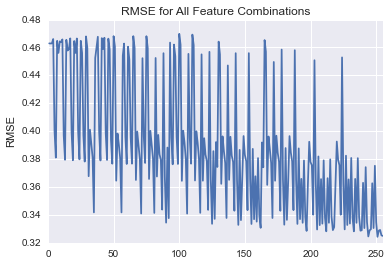

In [94]:
# Let's plot the RMSE for different features:
X = np.linspace(1,255,255)
plt.plot(X, ridge_RMSEs)
plt.title('RMSE for All Feature Combinations')
plt.ylabel('RMSE')
plt.xlim(0,255)

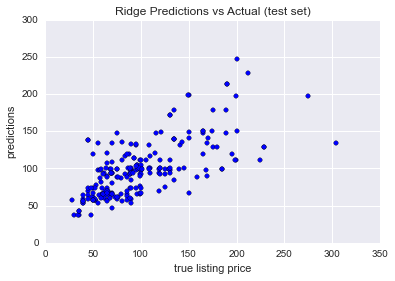

In [114]:
# Let's see how the predictions of the best ridge regression model compare to the true values
plt.scatter(np.exp(best_y_test),np.exp(best_predictions))
plt.xlabel('true listing price')
plt.ylabel('predictions')
plt.title('Ridge Predictions vs Actual (test set)')

#### The optimal Ridge Regression model uses 7 of the 8 potential features (all but No. of Bedrooms). Let's examine the residuals of the optimal model:

In [104]:
# create instance, train, predict, and calculate residuals for optimal ridge regression model
opt_ridge = Ridge()
X = combined_df[best_features]
y = combined_df.log_Price
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=999)
opt_ridge.fit(X_train, y_train)
predictions = opt_ridge.predict(X_test)
residuals = y_test - predictions

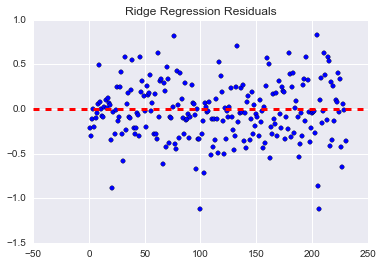

In [106]:
plt.scatter(np.linspace(1,len(residuals),len(residuals)),residuals)
plt.axhline(ls='--', linewidth=3, color='r')
plt.title('Ridge Regression Residuals')

#### The residuals look good, no apparent pattern and relatively homoscedastic. The last thing we'll do is take a look at the intercept and coefficients of the model

In [110]:
opt_ridge.intercept_

3.3816466358687398

In [175]:
feature_weights = zip(best_features,opt_ridge.coef_)
feature_weights.append(('Intercept',opt_ridge.intercept_))
print "Ridge regression features and their respective weights:\n"
feature_weights

Ridge regression features and their respective weights:



[('log_Review_Count', 0.0037594052092755625),
 ('Star_Rating', 0.1229148492981018),
 ('Has_Star_Rating', -0.52164951189817232),
 ('Capacity', 0.14083440343202161),
 ('Room_Type', 0.41659312183602859),
 ('City_NY', 0.11612188387616702),
 ('City_SF', 0.40450694834881329),
 ('Intercept', 3.3816466358687398)]

#### For my curiosity, let's look at the R-squared value:

In [117]:
ridge_r2 = metrics.r2_score(y_test, predictions)
print "R-Squared is: {:.4f}".format(ridge_r2)

R-Squared is: 0.5078


### More tuning to perform on Ridge model, let's see how the RMSE is affected by different values of the alpha parameter. Alpha affects the amount of regularization applied to the coefficients...

In [135]:
alphas = [10e-3, 10e-2, 10e-1, 1, 10, 100] #default is 1

In [136]:
r_squareds = []
RMSEs = []
for a in alphas:
    tune_ridge = Ridge(alpha=a)
    tune_ridge.fit(X_train, y_train)
    tune_predictions = tune_ridge.predict(X_test)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, tune_predictions))
    RMSEs.append(RMSE)
    print "Alpha: {}, RMSE: {:.6f}".format(a, RMSE)

Alpha: 0.01, RMSE: 0.323117
Alpha: 0.1, RMSE: 0.323227
Alpha: 1.0, RMSE: 0.324284
Alpha: 1, RMSE: 0.324284
Alpha: 10, RMSE: 0.326987
Alpha: 100, RMSE: 0.338383


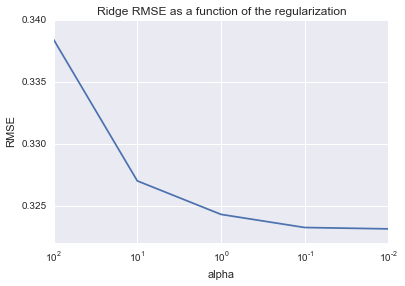

In [137]:
ax = plt.gca()

ax.plot(alphas, RMSEs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Ridge RMSE as a function of the regularization')
plt.show()

#### The RMSE stops decreasing, essentially when the alpha parameter becomes 0.1. An alpha of 1 has nearly identical performance, so we'll keep the optimal model as is.

### Last step, explore how the model performs over different training example sizes. This is useful to see if more data will be useful in improving the performance of the model

In [145]:
def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

In [144]:
def score_classifier(preds, y_test):
    return np.sqrt(metrics.mean_squared_error(y_test, preds))

In [150]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    
    # Generate predictions for the training and testing data
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    # Score the training and testing data
    train_RMSE = score_classifier(train_predictions, y_train)
    test_RMSE = score_classifier(test_predictions, y_test)
    
    print "RMSE for training set: {}".format(train_RMSE)
    print "RMSE score for test set: {}".format(test_RMSE)
    
    return (train_RMSE, test_RMSE)



In [151]:
train_RMSEs = []
test_RMSEs = []
for i in np.linspace(100,len(X_train),6, dtype='int'):
    clf = Ridge()
    X_train_batch = X_train[:i]
    y_train_batch = y_train[:i]
    train_RMSE, test_RMSE = train_predict(clf, X_train_batch, y_train_batch, X_test, y_test)
    train_RMSEs.append(train_RMSE)
    test_RMSEs.append(test_RMSE)

------------------------------------------
Training set size: 100
Training Ridge...
Done!
Training time (secs): 0.001
RMSE for training set: 0.309414139293
RMSE score for test set: 0.331583043954
------------------------------------------
Training set size: 217
Training Ridge...
Done!
Training time (secs): 0.001
RMSE for training set: 0.310518120619
RMSE score for test set: 0.334026480654
------------------------------------------
Training set size: 334
Training Ridge...
Done!
Training time (secs): 0.001
RMSE for training set: 0.299810341369
RMSE score for test set: 0.334698389732
------------------------------------------
Training set size: 452
Training Ridge...
Done!
Training time (secs): 0.001
RMSE for training set: 0.306253640704
RMSE score for test set: 0.3277045796
------------------------------------------
Training set size: 569
Training Ridge...
Done!
Training time (secs): 0.001
RMSE for training set: 0.306516508084
RMSE score for test set: 0.325726674757
----------------------

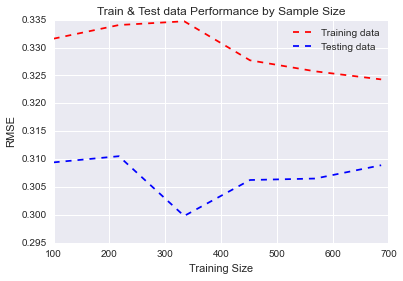

In [159]:
X = np.linspace(100,len(X_train),6, dtype='int')
plt.plot(X, test_RMSEs, 'r--', label='Training data')
plt.plot(X, train_RMSEs, 'b--', label='Testing data')
plt.legend(loc='best')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.title('Train & Test data Performance by Sample Size')

### Important: The gap between the model performance on the training and testing data suggests the mode is suffering from high variance and gathering additional data *would* improve model performance

## For comparison to the linear model, let's try a Gradient Boosted Regressor
### We'll use grid search to find the optimal parameters and score it by the RMSE

In [160]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

In [161]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 1],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9]
              }

gbr = GradientBoostingRegressor(n_estimators=1500)

gs_cv = GridSearchCV(gbr, param_grid, n_jobs=4).fit(X_train, y_train)

In [162]:
# best parameters
gs_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 5}

In [163]:
gs_cv.best_score_

0.58276417982184403

In [164]:
opt_gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01, max_depth=4, min_samples_leaf=5)

In [165]:
opt_gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [166]:
gbr_rmse = np.sqrt(metrics.mean_squared_error(y_test, opt_gbr.predict(X_test)))
gbr_rmse

0.32882960321392973

#### Of course, the simple linear regression model outperforms the complex GBRT. Let's see which features were most important

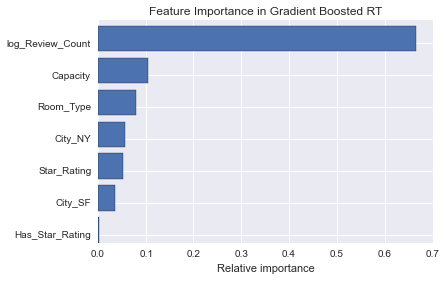

In [169]:
# sort importances
indices = np.argsort(opt_gbr.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(best_features)), opt_gbr.feature_importances_[indices])
plt.yticks(np.arange(len(best_features)) + 0.25, np.array(best_features)[indices])
_ = plt.xlabel('Relative importance')
plt.title('Feature Importance in Gradient Boosted RT')

#### Interestingly, Review Count is the most important feature. Since the simple Ridge Regression model outperforms this, we're not going to worry about it.

## Findings and Conclusion

The final Airbnb prediction model is a Ridge Regression model. It uses 7 features shown below, with their respective weights and the model intercept:

In [176]:
feature_weights

[('log_Review_Count', 0.0037594052092755625),
 ('Star_Rating', 0.1229148492981018),
 ('Has_Star_Rating', -0.52164951189817232),
 ('Capacity', 0.14083440343202161),
 ('Room_Type', 0.41659312183602859),
 ('City_NY', 0.11612188387616702),
 ('City_SF', 0.40450694834881329),
 ('Intercept', 3.3816466358687398)]

Our model was able to achieve an R-Square of 0.51, which means we're able to explain 51% of the variance in listing price with these features. This result is not bad, but certainly can be improved upon, most easily by collecting more data points.

This model does easily outperform the baseline model fit in the beginning, which simply used the average price of a listing in a city for its prediction.

The model was validated by using cross validation (splitting the data into training and testing sets) to ensure it did not overfit the data. Examination of the residuals confirmed that heteroscedasticity was not present in the model error.

A scatter plot of the true listing prices vs the model's predictions can be found below:

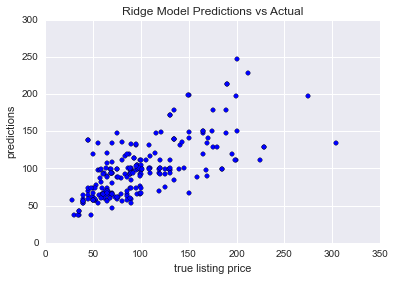

In [178]:
# Let's see how the predictions of the best ridge regression model compare to the true values
plt.scatter(np.exp(best_y_test),np.exp(best_predictions))
plt.xlabel('true listing price')
plt.ylabel('predictions')
plt.title('Ridge Model Predictions vs Actual')